In [128]:
import matplotlib.pyplot as plt 


from Lilygo.Recording import Recording, data_integrity
from Lilygo.Dataset import Dataset

from scipy import signal
from scipy.fft import fftshift
import numpy as np
from math import sqrt
from scipy import fft
from scipy.fft import fft
import pandas as pd
import glob
import os
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm_notebook
 

In [ ]:
def data_analysis(recordings_folder_path):
    for i in range(1):
        sample = os.listdir(recordings_folder_path)[i]
        with open(os.path.join(recordings_folder_path, sample)) as sample_json:
            labelled_sample = json.load(sample_json)
        print("Data Labels:", labelled_sample["labels"])
        print(
            "Data Fields:\n", labelled_sample["data"][0].keys()
        )  # Zero'th element because "data" field is a list containing a dictionary of values {[]}

        field_lengths = dict.fromkeys(
            labelled_sample["data"][0].keys(),
        )
        for key in field_lengths.keys():
            if (type(labelled_sample["data"][0][key]) is not int) and (
                type(labelled_sample["data"][0][key]) is not float
            ):
                field_lengths[key] = len(labelled_sample["data"][0][key])
            else:
                field_lengths[key] = 1
        print("\nNumber of entries per field:", field_lengths)

    for i in range(3):
        sample = os.listdir(recordings_folder_path)[i]
        with open(os.path.join(recordings_folder_path, sample)) as sample_json:
            labelled_sample = json.load(sample_json)
        print("Number of Data Dictionaries:", len(labelled_sample["data"]))

## Board Location 

In [105]:
def get_mag(trace, x, y, z):
    assert(x in trace.data and y in trace.data and z in trace.data)
    assert(len(trace.data[x].values) == len(trace.data[y].values) and len(trace.data[x].values) == len(trace.data[z].values))
    magn = [sqrt(a**2+trace.data[y].values[i]**2+trace.data[z].values[i]**2)for i, a in enumerate(trace.data[x].values)]
    return magn


def rolling_window_stride(array, window_size,freq):
    shape = (array.shape[0] - window_size + 1, window_size)
    strides = (array.strides[0],) + array.strides
    rolled = np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)
    return rolled[np.arange(0,shape[0],freq)]

def powerSpectrum(x, magn, thresh, filt_order, cutoff, band_type, title, xlim, ylim):
    #plt.close()
    Fs = int(x.samplerate)
    t = np.arange(0, x.total_time, 1/x.samplerate)
    # print(t)
    gated_magn = [0 if i < thresh else i for i in magn]

    butterworth = signal.butter(N = filt_order, Wn = cutoff, btype = band_type, output = "sos", fs = Fs)
    filt_magn = signal.sosfilt(butterworth, magn)

    #powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(filt_magn, Fs=Fs, NFFT = 256, noverlap = 128, pad_to = 256)
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(filt_magn, Fs=Fs, NFFT = 32, noverlap = 8, pad_to = 32)

    return powerSpectrum

In [120]:
def feature_extractor(filename):
    trace = Recording(filename, no_labels=False, mute=True)
    ax = trace.data["ax"]
    amagn = get_mag(trace, 'ax', 'ay', 'az')
    trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, trace.data['ax'].timestamps)

    amagnar = np.asarray(amagn)
    windows = rolling_window_stride(amagnar, 200, 100)
    

    perc75 = 0
    iqr = 0
    rms = 0
    
    for i in range(len(windows)):
        perc75 = perc75 + np.percentile(windows[i],75)
        iqr = iqr + np.percentile(windows[i],75) - np.percentile(windows[i],25)
        rms = np.sqrt(np.mean(windows[i]**2))

    perc75 = perc75/np.shape(windows)[0]
    iqr = iqr/np.shape(windows)[0]
    rms = rms/np.shape(windows)[0]
    

    PS = powerSpectrum(ax, amagn, 1.1, 20, 10, "lowpass", "Acc Mag", "std", 1)

    pss  = PS.mean(1)
    pss.flatten()    
    features = np.concatenate((np.array([perc75,iqr,rms]),pss))
    features.flatten()

    # print(features.shape)
   
    return features


def features_and_labels_constructor(data_folder_path: str):
    num_samples = len(os.listdir(data_folder_path))
    feature_matrix = np.zeros((num_samples,20)) # Create Matrix of Row Number: Num Samples; Col Number: 20
    label_vector = np.zeros((num_samples,1))
    for idx in tqdm_notebook(range(len(os.listdir(data_folder_path)))):
        filepath = data_folder_path + "/" + os.listdir(data_folder_path)[idx]
        feature_matrix[idx] = feature_extractor(filepath)
        trace = Recording(filepath, no_labels=False, mute=True)
        label_vector[idx] = trace.labels["board_loc"]
    
    print(feature_matrix.shape)
    return feature_matrix, label_vector


In [121]:
# print(feature_extractor("./data/pathdetection/group15_trace01.json"))



  0%|          | 0/167 [00:00<?, ?it/s]

(167, 20)


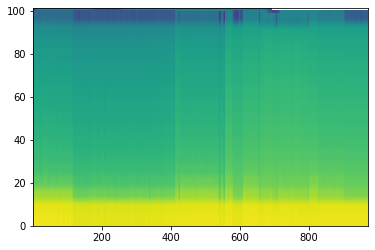

In [122]:
X, y  = features_and_labels_constructor("./data/mHealth_Ex2_Data")



In [95]:
# X = np.delete(X, 27)
# y = np.delete(y, 27)

In [157]:
def train_board_loc_classifier(model, X, y):
    kfolder = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 0)
    idx = 0
    for train_idx, test_idx in kfolder.split(X,y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Confusion Matrix Fold %d: %s"%(idx, confusion_matrix(y_test, y_pred)))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        print("Number of Samples to be classified")
        print("Number of correct classifications %d: %f"%(idx, accuracy_score(y_test, y_pred, normalize = True)))
        plt.show()
        idx +=1

Confusion Matrix Fold 0: [[13  1  0]
 [ 1 13  0]
 [ 1  0 13]]
Number of Samples to be classified
Number of correct classifications 0: 0.928571


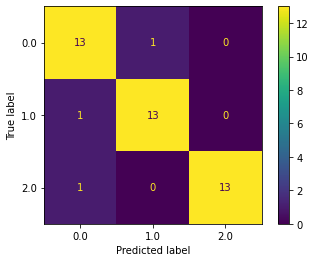

Confusion Matrix Fold 1: [[11  2  1]
 [ 1 13  0]
 [ 0  0 14]]
Number of Samples to be classified
Number of correct classifications 1: 0.904762


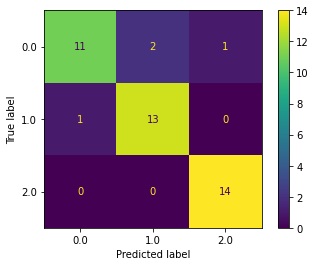

Confusion Matrix Fold 2: [[13  0  1]
 [ 2 10  1]
 [ 2  0 13]]
Number of Samples to be classified
Number of correct classifications 2: 0.857143


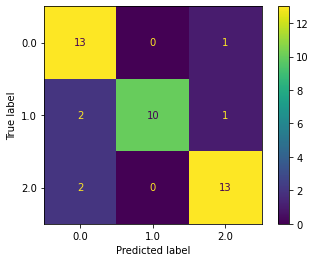

Confusion Matrix Fold 3: [[11  2  1]
 [ 1 12  0]
 [ 1  0 13]]
Number of Samples to be classified
Number of correct classifications 3: 0.878049


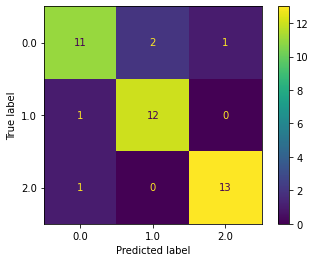

In [158]:
model = XGBClassifier(n_estimators = 100, max_depth = 10)
train_board_loc_classifier(model, X, y)

## Activity Recognition 

## Path Detection